<a href="https://colab.research.google.com/github/akhil189/Deep-Learning-in-Tensorflow-2.0/blob/master/CNNs/Image%20Classification/Transfer%20Learning/Transfer_Learning_TF_hub%20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
  % tensorflow_version 2.x

TensorFlow 2.x selected.


In [0]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import numpy as np
import tensorflow_hub as hub
from tensorflow.keras import layers

In [3]:
data_root = tf.keras.utils.get_file( 'flower_photos','https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz', untar=True)

228818944/228813984 [==============================] - 3s 0us/step


In [4]:
data_root

'/root/.keras/datasets/flower_photos'

In [5]:
path    = data_root
sub_folders = np.sort([name for name in os.listdir(path) if os.path.isdir(os.path.join(path,name))])
files = [len(os.listdir(os.path.join(path,i))) for i in sub_folders if os.path.isdir(os.path.join(path,i))]
print(sub_folders)
print(files)
print(' class --> no of examples')
for i,j in zip(sub_folders,files):
  print('class:{} --> {}'.format(i,j))
print('Total images: {}'.format(sum(files)))

['daisy' 'dandelion' 'roses' 'sunflowers' 'tulips']
[633, 898, 641, 699, 799]
 class --> no of examples
class:daisy --> 633
class:dandelion --> 898
class:roses --> 641
class:sunflowers --> 699
class:tulips --> 799
Total images: 3670


In [0]:
IMAGE_SHAPE = (224, 224)

Generating batches of data. Default batch_size is 32

In [7]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
image_data = image_generator.flow_from_directory(str(data_root), target_size=IMAGE_SHAPE)

Found 3670 images belonging to 5 classes.


In [8]:
for image_batch, label_batch in image_data:
  print("Image batch shape: ", image_batch.shape)
  print("Label batch shape: ", label_batch.shape)
  break

Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 5)


Importing Mobilenet v2 model

In [0]:
feature_extractor_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2" 

Wrapping the model as Keras.layer

In [0]:
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,input_shape=(224,224,3))

Passing a batch to the model to check output features shape

In [11]:
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

(32, 1280)


In [0]:
feature_extractor_layer.trainable = False

In [13]:
model = tf.keras.Sequential([ 
                              feature_extractor_layer,
                              layers.Dense(image_data.num_classes, activation='softmax')
                            ])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


Checking final layer's output shape

In [0]:
predictions = model(image_batch)

In [15]:
predictions.shape

TensorShape([32, 5])

In [0]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['acc'])

In [0]:
class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses = []
    self.batch_acc = []

  def on_train_batch_end(self, batch, logs=None):
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['acc'])
    self.model.reset_metrics()

In [18]:
steps_per_epoch = np.ceil(image_data.samples/image_data.batch_size)

batch_stats_callback = CollectBatchStats()

history = model.fit_generator(image_data, epochs=2,
                              steps_per_epoch=steps_per_epoch,
                              callbacks = [batch_stats_callback])

Epoch 1/2
115/115 [==============================] - 32s 277ms/step - loss: 0.6814 - acc: 0.8750
Epoch 2/2
115/115 [==============================] - 25s 218ms/step - loss: 0.3430 - acc: 0.9062


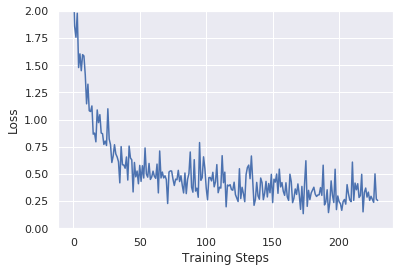

In [19]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(batch_stats_callback.batch_losses)

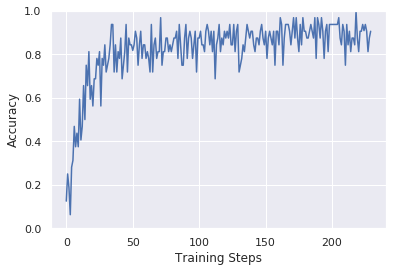

In [20]:
plt.figure()
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(batch_stats_callback.batch_acc)

In [21]:
class_names = sorted(image_data.class_indices.items(), key=lambda pair:pair[1])
class_names = np.array([key.title() for key, value in class_names])
class_names

array(['Daisy', 'Dandelion', 'Roses', 'Sunflowers', 'Tulips'],
      dtype='<U10')

In [0]:
predicted_batch = model.predict(image_batch)
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]

In [0]:
label_id = np.argmax(label_batch, axis=-1)

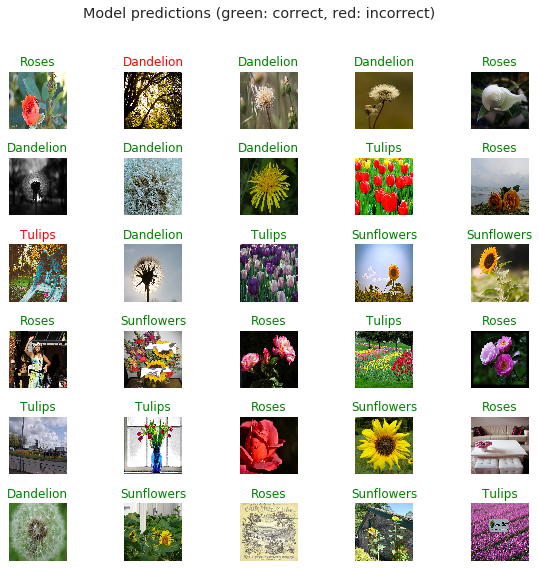

In [24]:
plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  color = "green" if predicted_id[n] == label_id[n] else "red"
  plt.title(predicted_label_batch[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")

In [0]:
# import time
# t = time.time()

# export_path = "/tmp/saved_models/{}".format(int(t))
# model.save(export_path, save_format='tf')

# export_path

In [0]:
# reloaded = tf.keras.models.load_model(export_path)

In [0]:
# result_batch = model.predict(image_batch)
# reloaded_result_batch = reloaded.predict(image_batch)

In [0]:
# abs(reloaded_result_batch - result_batch).max()

In [0]:
# import os, signal
# os.kill(os.getpid(), signal.SIGKILL)